# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

**Lvl 1:**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train = pd.read_csv('../0. Sklearn introduction/titanic/train.csv')
test = pd.read_csv('../0. Sklearn introduction/titanic/test.csv')
print('Train dataset')
print(train.info())
print('Test dataset')
print(test.info())

Train dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
Test dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
F

#### Взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
#### Кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )

Для начала сварим нужные фичи

In [3]:
from sklearn.preprocessing import Imputer

def prepare_df(df):
    X = df
    X["isMale"] = X.Sex.replace({"male": 1, "female":0})
    X.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)
    X = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
    imputer.fit(X)

    X_imputed = imputer.transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)
    if 'Survived' in df.columns:
        y = df.Survived
        X.drop('Survived', axis=1, inplace=True)
        return X, y 
    else:
        return X

In [4]:
X_train, y_train = prepare_df(df=train)
X_test = prepare_df(df=test)

C:\Users\mi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\mi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
Age           418 non-null float64
SibSp         418 non-null float64
Parch         418 non-null float64
Fare          418 non-null float64
isMale        418 non-null float64
Pclass_1      418 non-null float64
Pclass_2      418 non-null float64
Pclass_3      418 non-null float64
Embarked_C    418 non-null float64
Embarked_Q    418 non-null float64
Embarked_S    418 non-null float64
dtypes: float64(11)
memory usage: 36.0 KB


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [7]:
grid = {'criterion': ['gini', 'entropy'] 
       ,'max_depth' : np.arange(10,15,1)
       ,'min_samples_leaf' : np.arange(1,5,1)
       ,'max_features' : np.arange(1,len(X_train.columns), 1)
       }
gs = GridSearchCV(DecisionTreeClassifier(), grid, scoring='accuracy', cv=5)
gs.fit(X_train, y_train);

C:\Users\mi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [8]:
print(f'Best score : {gs.best_score_}')
print(f'Best params : {gs.best_params_}')

Best score : 0.8271604938271605
Best params : {'criterion': 'entropy', 'max_depth': 14, 'max_features': 7, 'min_samples_leaf': 4}


Формируем сабмит

In [9]:
y_pred = gs.best_estimator_.predict(X_test)

test = pd.read_csv('../0. Sklearn introduction/titanic/test.csv')
submit = test[['PassengerId']]
submit['Survived'] = y_pred
submit.to_csv('submit.csv', index=False)

C:\Users\mi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


#### Определить самые важные фичи

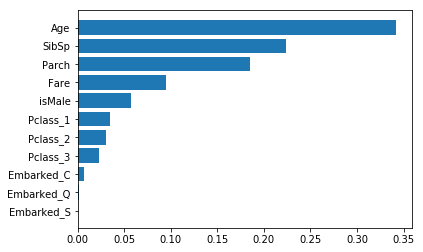

In [10]:
importances = sorted(gs.best_estimator_.feature_importances_, reverse=False)
indices = np.argsort(importances)[::-1]
plt.barh(np.arange(len(importances)), importances)
plt.yticks(indices,X_train.columns);

* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

In [11]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    #return export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names)
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [12]:
# не захотел этот кусок кода заводиться 
'''
# !pip install pydot
# !pip search graphviz 
import pydot 
import graphviz

graph = pydot.graph_from_dot_data(get_tree_dot_view(gs.best_estimator_, list(X_train.columns), X_train.columns))
graph
graph[0].write_png('tree.png')
'''

"\n# !pip install pydot\n# !pip search graphviz \nimport pydot \nimport graphviz\n\ngraph = pydot.graph_from_dot_data(get_tree_dot_view(gs.best_estimator_, list(X_train.columns), X_train.columns))\ngraph\ngraph[0].write_png('tree.png')\n"

In [13]:
get_tree_dot_view(gs.best_estimator_, list(X_train.columns), X_train.columns)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="isMale <= 0.5\nentropy = 0.961\nsamples = 891\nvalue = [549, 342]\nclass = Age", fillcolor="#e5813960"] ;
1 [label="Pclass_1 <= 0.5\nentropy = 0.824\nsamples = 314\nvalue = [81, 233]\nclass = SibSp", fillcolor="#399de5a6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Pclass_2 <= 0.5\nentropy = 0.938\nsamples = 220\nvalue = [78, 142]\nclass = SibSp", fillcolor="#399de573"] ;
1 -> 2 ;
3 [label="Embarked_S <= 0.5\nentropy = 1.0\nsamples = 144\nvalue = [72, 72]\nclass = Age", fillcolor="#e5813900"] ;
2 -> 3 ;
4 [label="Age <= 30.1\nentropy = 0.886\nsamples = 56\nvalue = [17, 39]\nclass = SibSp", fillcolor="#399de590"] ;
3 -> 4 ;
5 [label="Fare <= 15.373\nentropy = 0.811\nsamples = 52\nvalue = [13, 39]\nclass = SibSp", fillcolor="#399de5aa"] ;
4 -> 5 ;
6 [label="Parch <= 0.5\nentropy = 0.91\nsamples = 40\nvalue = [13, 27]\nclass = SibSp", fillcolor="#399de584"] ;
5 -> 6 ;
7 [label="Fare <

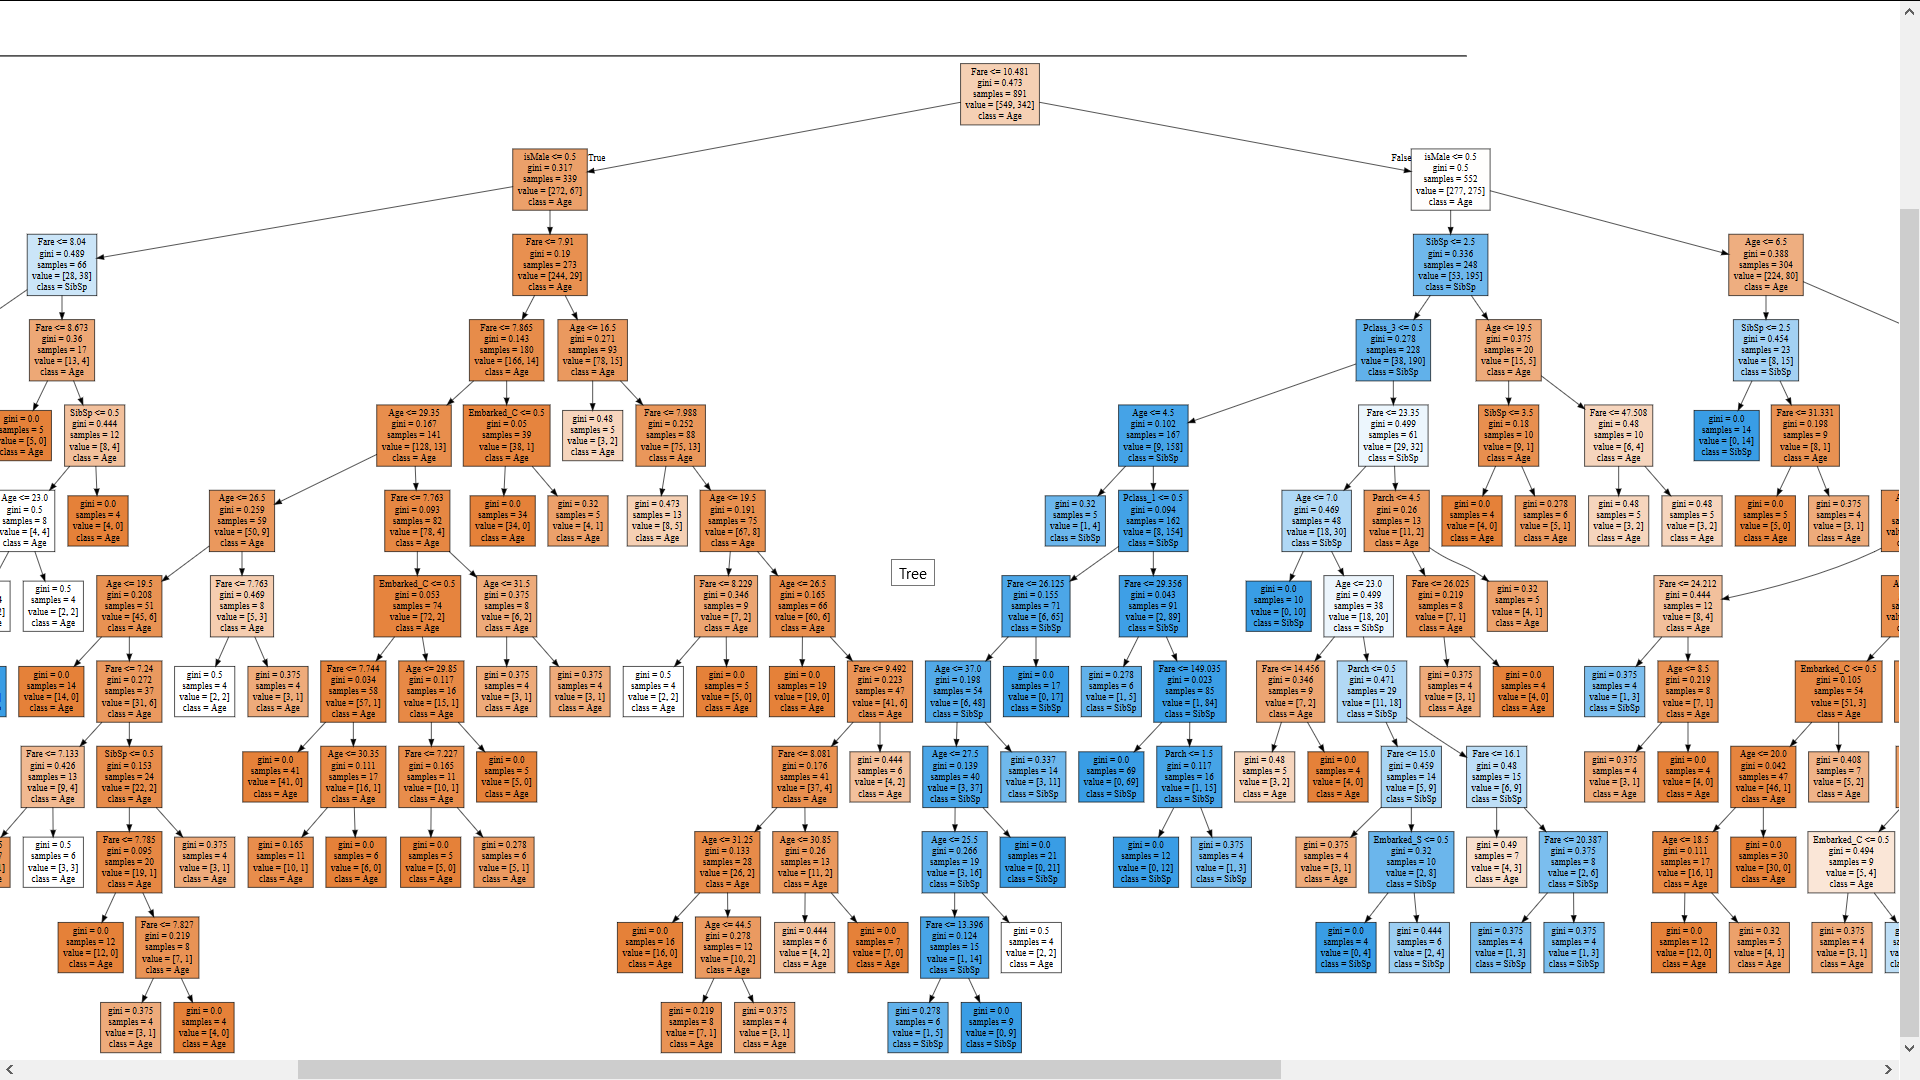

In [14]:
from IPython.display import Image
Image(filename='tree.png')

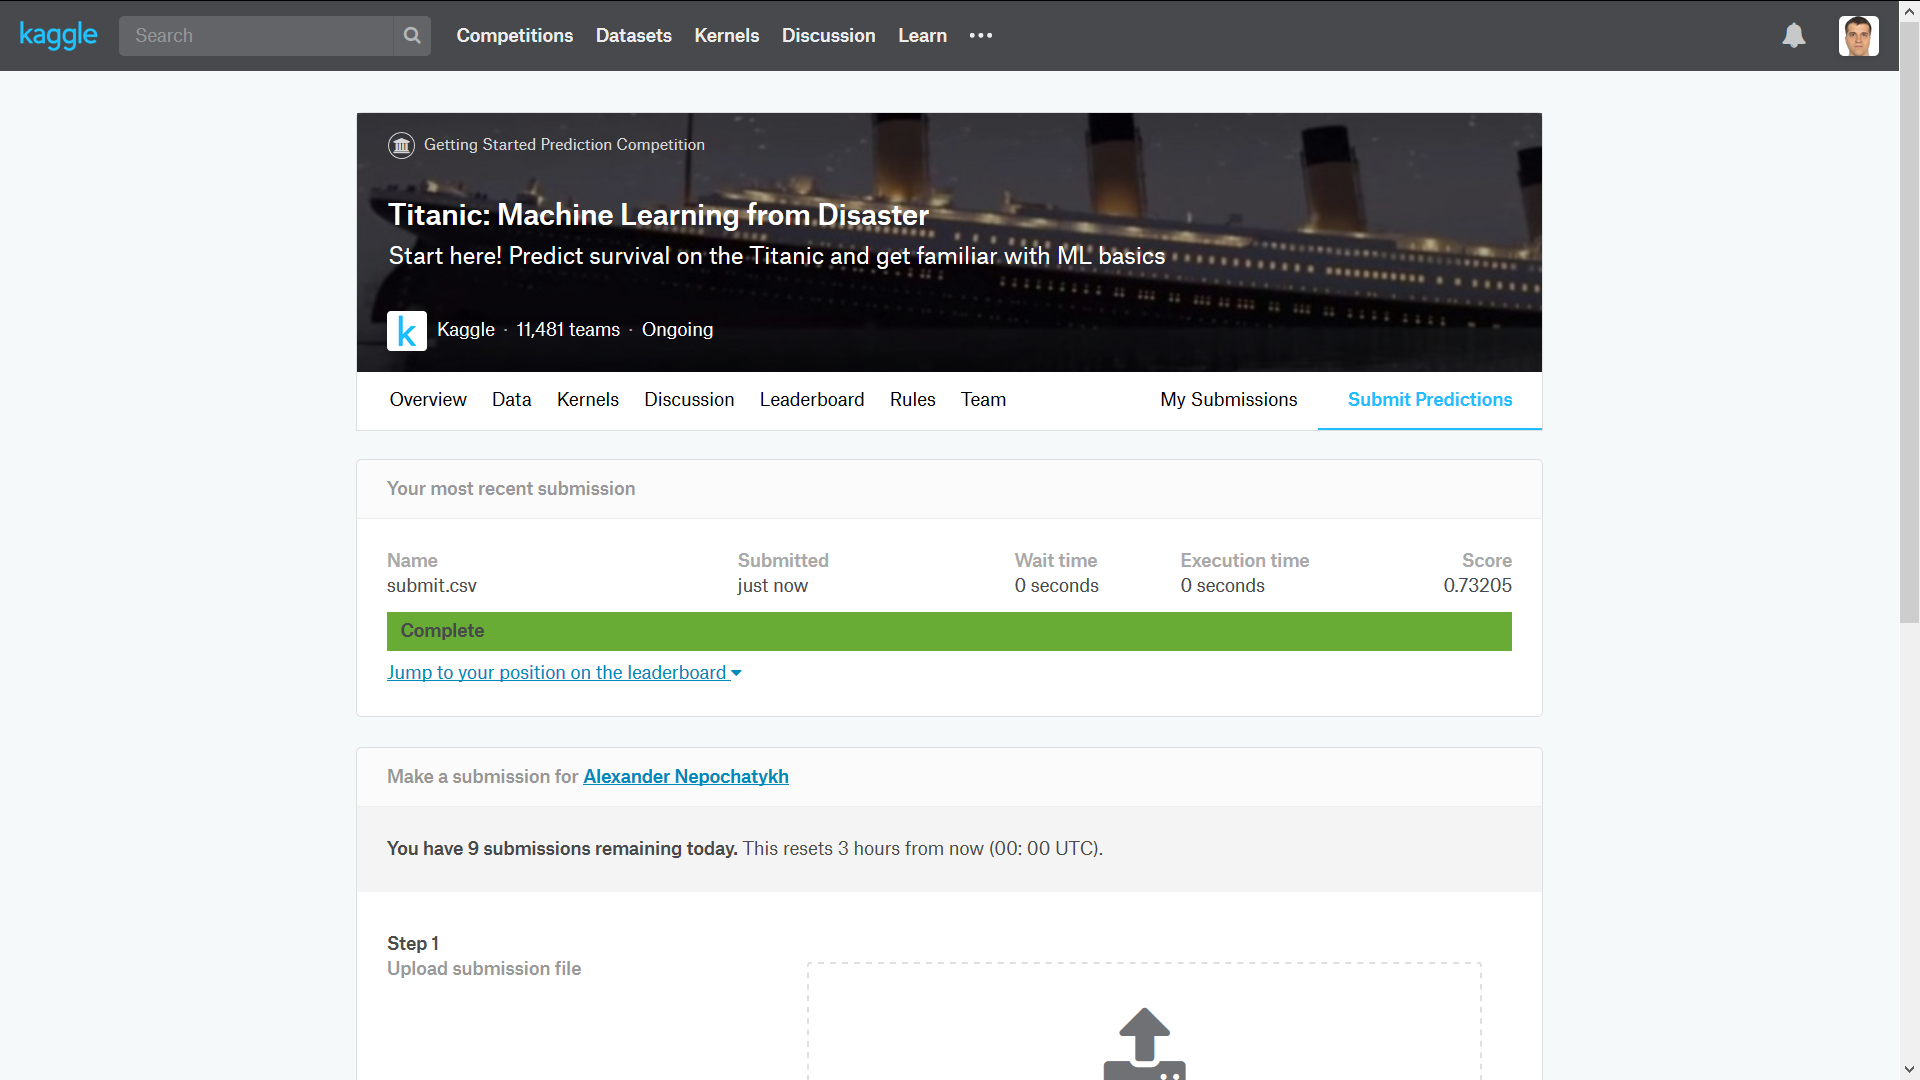

In [15]:
Image(filename='submission.png')